## Self supervised large scale generalisatiom

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091920/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/self-supervised/train.json"



In [3]:
is_download_files= False

In [4]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [5]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [6]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [7]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [8]:
%%time

if is_download_files:
    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [9]:
!ls -l $local_temp_pred_dir | wc -l

     100


In [10]:
default_threshold =  0.95
threshold_config =  {l: { "confidence":default_threshold}  for l in label_order}


In [11]:
threshold_config

{'False': {'confidence': 0.95}, 'True': {'confidence': 0.95}}

In [12]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [13]:
def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)

        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        low_quality_frames_per_interaction = []


        for k,t in threshold_config.items():
            conf_median = t["confidence"]
            conf_std_median = 1.0
            
            # HQ filter query
            high_qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                high_qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
            df_sub = df.query(high_qry)
            sample = min(1000, len(df_sub) )
            high_quality_frames_per_interaction.append(df_sub.sample(n=sample))


            # Low quality filter query
            conf_min = 0.8
            conf_std_min = 0.0
            low_qry = "prediction == '{}' and confidence < {} and confidence_std > {}" .format(k, conf_min, conf_std_min)
            if not use_std:
                low_qry = "prediction == '{}' and confidence < {} " .format(k, conf_min)
            df_low = df.query(low_qry)
            sample=min(1000, len(df_low) )
            low_quality_frames_per_interaction.append(df_low.sort_values(by=["prediction", "confidence_std"]).head(n=sample))
           

        high_quality_df = pd.concat(high_quality_frames_per_interaction)
        low_quality_df = pd.concat(low_quality_frames_per_interaction)


        list_df_high_quality.append(high_quality_df)
        list_df_low_quality.append(low_quality_df)


    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary), pd.concat(list_df_low_quality)



In [14]:


def is_in_training_pubmed(df, training_df):
    return df["abstract_id"].isin(training_df["abstract_id"])

In [15]:
download_file(s3_training, local_temp_wk_dir)
training_data_file = os.path.join(local_temp_wk_dir, s3_training.split("/")[-1])
data_training_full_df = pd.read_json(training_data_file)

In [16]:
%%time 


df_high_quality_threshold, df_summary, df_low_quality_threshold = get_summary_df (local_temp_pred_dir)
df_high_quality_threshold[ "RecordInTrainingData"] = is_in_training_pubmed( df_high_quality_threshold, data_training_full_df)
df_summary["RecordInTrainingData"] = is_in_training_pubmed( df_summary, data_training_full_df)
df_low_quality_threshold[ "RecordInTrainingData"]= is_in_training_pubmed( df_low_quality_threshold, data_training_full_df)

CPU times: user 25.1 s, sys: 2.79 s, total: 27.9 s
Wall time: 28 s


In [17]:
df_summary.dtypes

prediction               object
confidence              float64
confidence_std          float64
abstract_id               int64
RecordInTrainingData       bool
dtype: object

In [18]:
df_summary.groupby("prediction")["confidence"].describe()

,count,mean,std,min,25%,50%,75%,max
prediction,,,,,,,,
False,2019270.0,0.990737,0.045619,0.500013,0.998954,0.999207,0.999253,0.999648
True,222440.0,0.932311,0.116868,0.500005,0.932357,0.990719,0.997000,0.998745


In [19]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


In [20]:
df_high_quality_threshold.shape, df_summary.shape

((190090, 9), (2241710, 5))

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


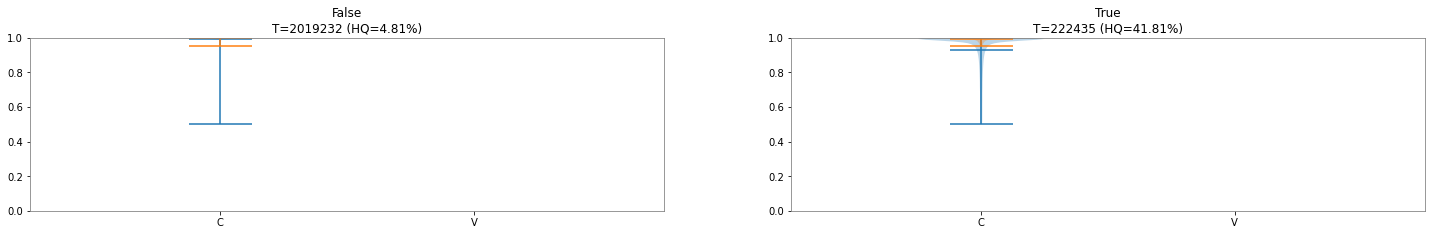

In [21]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [22]:
df_low_quality_threshold["prediction"].value_counts()

False    31142
True     28902
Name: prediction, dtype: int64

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


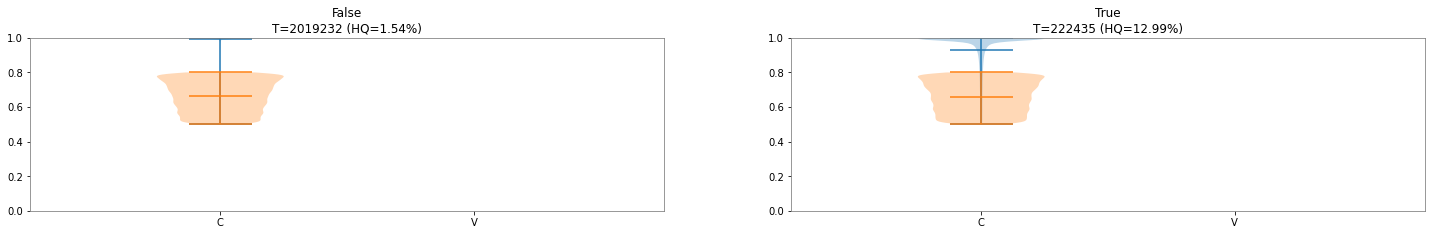

In [23]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_low_quality_threshold, gs[0])



In [24]:
df_summary.shape

(2241710, 5)

In [25]:
df_summary[["confidence","prediction"]].groupby("prediction").describe().T

prediction               False           True
confidence count  2.019270e+06  222440.000000
           mean   9.907368e-01       0.932311
           std    4.561930e-02       0.116868
           min    5.000131e-01       0.500005
           25%    9.989537e-01       0.932357
           50%    9.992068e-01       0.990719
           75%    9.992532e-01       0.997000
           max    9.996483e-01       0.998745

In [26]:
%%time

def prepare_predictions_summary(df_full, df_high_quality_threshold):
    
    
    df_full = df_full[~df_full.RecordInTrainingData].copy()
    
    df_high_quality_threshold = df_high_quality_threshold[~df_high_quality_threshold.RecordInTrainingData].copy()


        
    
    summary_df = pd.DataFrame(df_full
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})

    

    thresh_df = pd.DataFrame(df_high_quality_threshold\
              .groupby('prediction').size())\
              .rename(columns={0: "thresh_count"})
    
    
    
    
    dfs = [summary_df,  thresh_df]
    result_df = pd.DataFrame()
    
    for df in dfs:
        result_df = result_df.merge(df, left_index=True,  right_index=True, how="outer")
        
        
    for col in result_df.columns:
        result_df.loc["Total",col] = result_df[col].sum()
        
    result_df = result_df.fillna(0)
        
    result_df = result_df.astype(int)
    return result_df


latex_df_results = prepare_predictions_summary(df_summary, df_high_quality_threshold)

print(latex_df_results.to_latex( index=True))

latex_df_results

\begin{tabular}{lrr}
\toprule
{} &  all\_count &  thresh\_count \\
prediction &            &               \\
\midrule
False      &    2019232 &         97082 \\
True       &     222435 &         93004 \\
Total      &    2241667 &        190086 \\
\bottomrule
\end{tabular}

CPU times: user 259 ms, sys: 59.1 ms, total: 318 ms
Wall time: 322 ms


,all_count,thresh_count
prediction,,
False,2019232,97082
True,222435,93004
Total,2241667,190086


In [27]:
df_high_quality_threshold.groupby(["prediction"]).size()

prediction
False    97083
True     93007
dtype: int64

In [28]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [29]:

local_file_high_q_sample = os.path.join(local_temp, "highquality_sample.json")
local_file_low_q_sample = os.path.join(local_temp, "lowquality_sample.json")

df_high_quality_threshold.to_json(local_file_high_q_sample,  orient='records')
df_low_quality_threshold.to_json(local_file_low_q_sample,   orient='records')




In [30]:
upload_file( local_file_high_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))
upload_file( local_file_low_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))



In [47]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
import pandas as pd
import tempfile

def get_sim_scores(ref_file_or_df, target_file_or_df, n_gram, additional_target_cols):
    marker_ref_file = ref_file_or_df
    marker_target_file = target_file_or_df

    
    if isinstance(ref_file_or_df, str):
        df_ref_marker = pd.read_json(marker_ref_file)
        df_target_marker =  pd.read_json(marker_target_file)
    else:
        df_ref_marker = marker_ref_file
        df_target_marker = marker_target_file
    
    comparer =  SimilarityComparer(n_gram=n_gram, max_features=1050)
    comparison_result = comparer(df_ref_marker["abstract"].tolist(), df_target_marker["abstract"].tolist())
    
    sim_score = comparison_result[0]
    
    df_target_marker["sim_score"]  = comparison_result[0]
    return df_target_marker
    
def plot_sim_scores(df, ax, interaction, title_prefix ):
    
    for i, interaction_type in enumerate(interaction): 
        df_interaction = df.query(f"interaction_type == '{interaction_type}'")
        
        if len(df_interaction) ==0: continue
            
        ax[i].set_ylim(0,1)
        
        ax[i].set_title(f"{title_prefix} {interaction_type}")

        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')
        
        

        ax[i].violinplot(df_interaction["best_score"],  showmeans=True )

In [43]:
df_high_quality_threshold.shape

(190090, 9)

In [48]:
df_sim_score_high = get_sim_scores(data_training_full_df, df_high_quality_threshold, n_gram=1, additional_target_cols=list(df_high_quality_threshold.columns))

df_sim_score_high.head()


,abstract_id,abstract,false,true,prediction,confidence,confidence_std,raw_confidence,RecordInTrainingData,sim_score
9,20791874,"When breathing air, the average arterial oxyge...",0.999210,0.000790,False,0.999210,NaN,[0.9992102384567261],False,0.225449
10,20791875,A comparative trial of co-trimoxazole and chlo...,0.999268,0.000732,False,0.999268,NaN,[0.9992682337760921],False,0.358464
12,20791877,Subtyping of hepatitis B antigen (HBA) in bloo...,0.999327,0.000673,False,0.999327,NaN,[0.9993270635604851],False,0.267713
4,20791862,An abrupt method of terminating prescriptions ...,0.999256,0.000744,False,0.999256,NaN,[0.9992560744285581],False,0.378387
13,20791880,"When a patient presents with wheezing, pulmona...",0.999311,0.000689,False,0.999311,NaN,[0.999311208724975],False,0.232936


<AxesSubplot:>

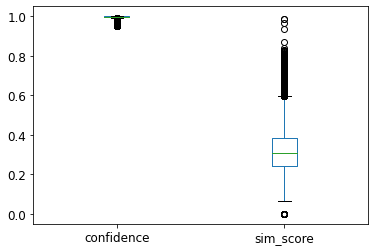

In [49]:
df_sim_score_high[["confidence","sim_score"]].plot.box()

<AxesSubplot:>

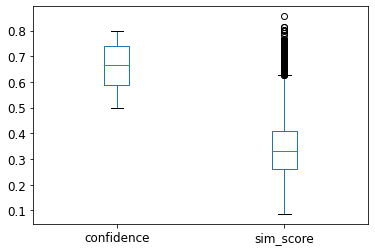

In [50]:
df_sim_score_low = get_sim_scores(data_training_full_df, df_low_quality_threshold, n_gram=1, additional_target_cols=list(df_low_quality_threshold.columns))
df_sim_score_low[["confidence","sim_score"]].plot.box()

In [51]:
def plot_box_sim_scores_confidence(df_high, df_low):
    p_unique = sorted(list(df_high["prediction"].unique()))
    
    _, axes = plt.subplots(1, len(p_unique), figsize=(30 ,8))
    
    for i, l in enumerate(p_unique):
        dh = df_high.query(f"prediction == '{l}'")
        dl = df_low.query(f"prediction == '{l}'")
        
        dl = dl[["confidence", "sim_score"]]
        dh = dh[["confidence", "sim_score"]]                   
                    
        
        data = dh.values.T.tolist()
        data.extend(dl.values.T.tolist())
      
        ax=axes[i]
        ax.boxplot(data, showmeans=True)
        ax.set_title(l)
        ax.set_xticklabels(["HC","HS", "LC", "LH"])


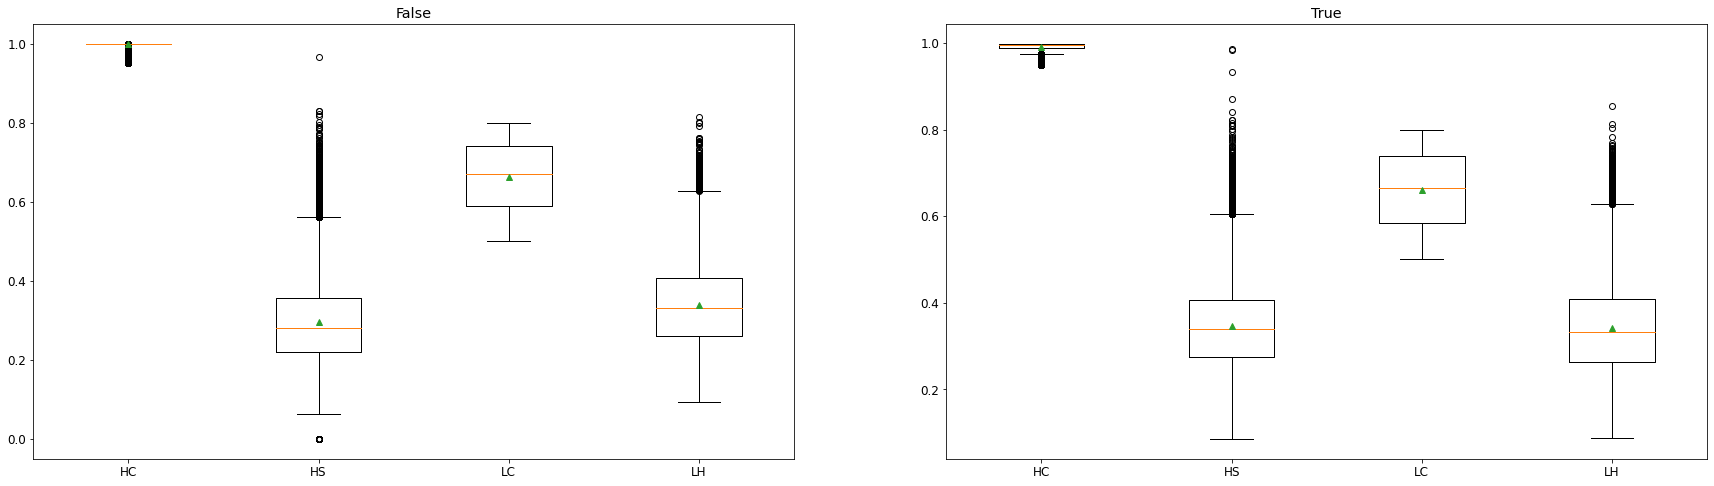

In [52]:
plot_box_sim_scores_confidence(df_sim_score_high, df_sim_score_low)

In [53]:
df_sim_score_high[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False         97083.0  0.998102  0.004719  0.950005  0.999026  0.999211   
True          93007.0  0.990446  0.010945  0.950000  0.988063  0.995639   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.999255  0.999640   97083.0  0.295319  0.100436  0.000000   
True        0.997493  0.998703   93007.0  0.345798  0.097307  0.085003   

                                                    
                 25%       50%       75%       max  
prediction                                          
False       0.220088  0.280409  0.356699  0.966071  
True        0.275631  0.338254  0.407334  0.987141

In [54]:
df_sim_score_low[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False         31142.0  0.663448  0.087475  0.500013  0.589295  0.669999   
True          28902.0  0.660325  0.087674  0.500005  0.585394  0.665283   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.741396  0.799999   31142.0  0.339506  0.104105  0.093019   
True        0.738018  0.799998   28902.0  0.340747  0.104079  0.086244   

                                                    
                 25%       50%       75%       max  
prediction                                          
False       0.261375  0.331301  0.408063  0.815471  
True        0.262236  0.331923  0.408793  0.855620